In [1]:
! pip install -q -U langchain_core langgraph langchain-google-genai tavily-python langchain-community

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.state import START,END,StateGraph,CompiledStateGraph
from dotenv import load_dotenv
import os
from IPython.display import display,Image
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode,tools_condition

load_dotenv()



True

In [4]:
google_api_key = os.getenv("GEMINI_API_KEY")
llm : ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=google_api_key)
tool = TavilySearchResults(max_results=2)

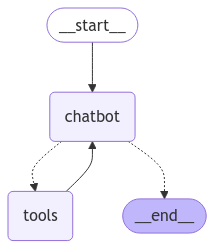

In [21]:
llm_with_tools = llm.bind_tools([tool])

class State(TypedDict):
    messages: Annotated[list,add_messages]    

workflow:StateGraph = StateGraph(State)

def chatbot(state:State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

workflow.add_node("chatbot",chatbot)
workflow.add_node("tools",ToolNode(tools=[tool]))

workflow.add_edge(START,"chatbot")
workflow.add_conditional_edges("chatbot",tools_condition)

workflow.add_edge("tools","chatbot")
graph : CompiledStateGraph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [34]:
content = "What is google"
events = graph.stream({"messages"  : [("user",content)]},stream_mode="values")
for event in events:
    if "messages" in event:
       event["messages"][-1].pretty_print() 
    

================================ Human Message =================================

What is google
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (349da03a-d04f-4c0e-b32c-bf622b271cac)
 Call ID: 349da03a-d04f-4c0e-b32c-bf622b271cac
  Args:
    query: What is google
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://about.google/", "content": "Google is a company that organizes the world's information and makes it accessible and useful. Learn about its products, AI, commitments, career certificates, doodles and company news."}, {"url": "https://www.techopedia.com/definition/5359/google", "content": "Google is an internet search engine that uses a proprietary algorithm to retrieve and order relevant and dependable sources of data. Learn about Google's history, mission, products, and challenges from Techopedia's experts."}]
============

## Adding Memory in the chatbot

In [47]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.state import START,END,StateGraph,CompiledStateGraph
from langchain_core.messages import HumanMessage,AIMessage
from dotenv import load_dotenv
import os
from IPython.display import display,Image
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver # This line is different

load_dotenv()

memory = MemorySaver()

In [36]:
google_api_key = os.getenv("GEMINI_API_KEY")
llm : ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=google_api_key)
tool = TavilySearchResults(max_results=2)

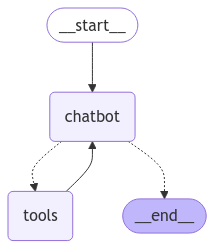

In [37]:
llm_with_tools = llm.bind_tools([tool])

class State(TypedDict):
    messages: Annotated[list,add_messages]    

workflow:StateGraph = StateGraph(State)

def chatbot(state:State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

workflow.add_node("chatbot",chatbot)
workflow.add_node("tools",ToolNode(tools=[tool]))

workflow.add_edge(START,"chatbot")
workflow.add_conditional_edges("chatbot",tools_condition)

workflow.add_edge("tools","chatbot")
graph : CompiledStateGraph = workflow.compile(checkpointer=memory) # This line is different

display(Image(graph.get_graph().draw_mermaid_png()))


In [48]:
config = {"configurable" : {"thread_id" : "1"}}
content = "Hi! there my name is Shahmir"

events = graph.stream({"messages" :[("user",content)]},config,stream_mode='values')

for event in events :
 event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi! there my name is Shahmir
================================== Ai Message ==================================

Hi Shahmir, nice to meet you! 👋  What can I do for you today? 😊


In [49]:
config = {"configurable" : {"thread_id" : "1"}}
content = "What is my name ?"

events = graph.stream({"messages" :[("user",content)]},config,stream_mode='values')

for event in events :
 event['messages'][-1].pretty_print()

================================ Human Message =================================

What is my name ?
================================== Ai Message ==================================

Your name is Shahmir! 😊  I remember that from our first interaction. 😄


In [51]:
config = {"configurable" : {"thread_id" : "2"}} # Changed thread_id
content = "What is my name ?"

events = graph.stream({"messages" :[("user",content)]},config,stream_mode='values')

for event in events :
 event['messages'][-1].pretty_print()

================================ Human Message =================================

What is my name ?
================================== Ai Message ==================================

I do not have access to personal information like your name.


In [52]:
config = {"configurable" : {"thread_id" : "1"}} # Again I changed my thread_id to 1
content = "What is my name ?"

events = graph.stream({"messages" :[("user",content)]},config,stream_mode='values')

for event in events :
 event['messages'][-1].pretty_print()

================================ Human Message =================================

What is my name ?
================================== Ai Message ==================================

Your name is Shahmir!  I remember you told me that earlier. 😊  Is there anything else I can help you with?


## Adding Human In The Loop

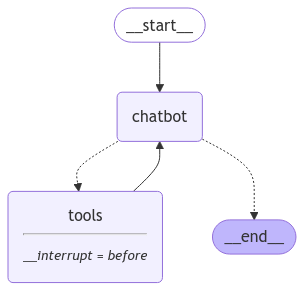

In [53]:
# Everything is same as done above before this step

graph : CompiledStateGraph = workflow.compile(checkpointer=memory, interrupt_before=["tools"]) # This line is different

display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
config = {"configurable" : {"thread_id" : "3"}}
content = "How is the weather today in Islamabad ?"

events = graph.stream({"messages" :[("user",content)]},config,stream_mode='values')

for event in events :
 event['messages'][-1].pretty_print()

================================ Human Message =================================

How is the weather today in Islamabad ?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (d5c1faef-e0d1-4f23-aea6-45b08328f812)
 Call ID: d5c1faef-e0d1-4f23-aea6-45b08328f812
  Args:
    query: weather in Islamabad today


In [ ]:
snapshot = graph.get_state(config)
existing_message =snapshot.values["messages"][-1]
existing_message.tool_calls


AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Islamabad today"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-9ddb3e94-504d-48f6-889f-cb22d5fcd1fc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Islamabad today'}, 'id': 'd5c1faef-e0d1-4f23-aea6-45b08328f812', 'type': 'tool_call'}], usage_metadata={'input_tokens': 148, 'output_tokens': 23, 'total_tokens': 171, 'input_token_details': {'cache_read': 0}})